# Read CSV to make diNT PWM used for looking up the scores

In [1]:
import csv

diNT_csv_dictionary = {}

#opens csv file, reads into a dictionary
with open('diNTpwm_fordict.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        diNT_csv_dictionary[row['dinucleotide'], row['position']] = row['efficiency']

In [1]:
# scan in the manually created Dinucleotide PWM of TIS efficiency



# diNT PWM score TIS

``  1 , 2,  3,  4,  5,  6,  7 ``

`` -6, -5, -4, -3, -2, -1, +4, +5 ``


In [2]:
#have to scan through each dinucleotide position in seq
#get the efficiency and multiply together
#save into table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import Seq

import operator
import functools

import math

import re

import numpy as np 
import pylab 
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Alphabet import generic_dna, generic_rna


import numpy
import random
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import generic_rna


# compartmentalized functions for extracting sequenes

In [3]:
def get_RNA_seq(filename):
    
    RNA_seq_list = []
    
    for seq_record in SeqIO.parse(filename,"fasta"):
        #may fail b/c of transcribe
        try:
            RNA_seq_list.append(seq_record.seq.transcribe())
        except ValueError:
            RNA_seq_list.append(seq_record.seq)
    return RNA_seq_list
    


In [4]:
def get_first_capital_character(seq):
    for i, c in enumerate(seq):
        if c.isupper():
            return i

In [5]:
def get_first_TIS(RNA_seq_list, species):

    if species == "V":

        v_RNA_seq_list = []
        for v_RNA_seq in RNA_seq_list:
            v_TIS_seq = v_RNA_seq[24:35]
            
            if len(v_TIS_seq) == 11:
                v_RNA_seq_list.append(v_TIS_seq)
            

        return v_RNA_seq_list
    
    else:
        TIS_seq_list = []

        for seq in RNA_seq_list:

            start_codon_index = get_first_capital_character(seq)

            TIS_seq = seq[start_codon_index-6:start_codon_index+5].upper()

            if len(TIS_seq) == 11:

                TIS_seq_list.append(TIS_seq)
            

        return TIS_seq_list

# #V for viral
# #H for human
# #G for gemini
# #A for arabidopsis

# def get_first_TIS(RNA_seq_list,species):
    

            
#     elif species == "H":
        
#         h_RNA_seq_list = []
#         for h_RNA_seq in RNA_seq_list:
#             h_RNA_seq_list.append(h_RNA_seq[30:41])
#         return h_RNA_seq_list
    
#     elif species == "G":
        
#         g_RNA_seq_list = []
#         for g_RNA_seq in RNA_seq_list:
#             g_RNA_seq_list.append(g_RNA_seq[29:40])
#         return g_RNA_seq_list
# #     elif species == "A":
# #         for a_RNA_seq in RNA_seq_list:
# #             v_RNA_seq[24:35]


# extract diNT from TIS_list and discard common AUG

In [6]:
def diNT_tuple_gen(TIS_list):
    
    # MAKES A LIST OF DINT TUPLES FOR EACH TIS DISCARDING THE AUG - saves the diNT and its position
    seq_dint_tuple_list = []
    
    for i in range(len(TIS_list)):

        for j in range(0,5):
            seq_dint_tuple_list.append((str(TIS_list[i][j:j+2]), j+1))

        # add dint position 6
        seq_dint_tuple_list.append((TIS_list[i][5]+TIS_list[i][9], 6))


        # add dint position 7
        seq_dint_tuple_list.append((TIS_list[i][9]+TIS_list[i][10], 7))
    
    return seq_dint_tuple_list

In [7]:
# teststst = get_first_TIS(get_RNA_seq(sv_filename),"V")

# wergtsergerh = diNT_tuple_gen(teststst)


# pwm_scores_per_seq = []
# for i in range(len(wergtsergerh)):
#     pwm_scores_per_seq.append(PWM(wergtsergerh[i][0],str(wergtsergerh[i][1])))

# len(pwm_scores_per_seq)

# [pwm_scores_per_seq[x:x+7] for x in range(0, len(pwm_scores_per_seq),7)]



# #     # have to multiply every 7 indices together to get single PWM score per sequence
# #     PWM_scores_seq = []
# #     for i in range(len(list_of_tuples_by_seven)):
# #         PWM_scores_seq.append(functools.reduce(operator.mul, list_of_tuples_by_seven[i], 7))
    
# #     return PWM_scores_seq

# pwm_scores_per_seq

# wergtsergerh


# define PWM score lookup function

In [8]:
def PWM(dinucleotide, position):
    #convert efficiency into float
    return float(diNT_csv_dictionary[dinucleotide, position])

In [9]:
#first index is 0 to 6
#2nd index is from 0 to 1

#have to accumulate every 7 PWMs

def score_seq_with_PWM(seq_dint_tuple_list):
    
    PWM_diNT_scores_seq = []
    
    #loop through all the tuples in the dint tuple list
    for i in range(len(seq_dint_tuple_list)):
        
        #score each diNT, save the position and store into another list PWM_diNT_scores_seq
        PWM_diNT_scores_seq.append(PWM(seq_dint_tuple_list[i][0], str(seq_dint_tuple_list[i][1])))


    #group every 7 tuples which is a single sequence
    list_of_tuples_by_seven = [PWM_diNT_scores_seq[x:x+7] for x in range(0, len(PWM_diNT_scores_seq),7)]


    # have to multiply every 7 indices together to get single PWM score per sequence
    PWM_scores_seq = []
    for i in range(len(list_of_tuples_by_seven)):
        PWM_scores_seq.append(functools.reduce(operator.mul, list_of_tuples_by_seven[i], 7))
    
    return PWM_scores_seq


In [10]:
def convert_to_Pandas_series_adjust_K_val(PWM_scores_seq):
    #convert to pandas series, a datastructure, to easily manipulate
    pandas_PWM_scores = pd.Series(PWM_scores_seq)
    
                                                        #CHECK THIS COEFFICIENT
    adjusted_PWM_scores = pandas_PWM_scores*math.exp(4.602730)
    
    return adjusted_PWM_scores

# Load sequences into differnet TIS lists, from #30_ATG_rest and transcribe to RNA

In [11]:
def analysis_pipeline(file):
        
    seqs = get_first_TIS(get_RNA_seq(file[0]),file[1])
    efficiencies = convert_to_Pandas_series_adjust_K_val(score_seq_with_PWM(diNT_tuple_gen(seqs)))
    
    return efficiencies
    
    

In [12]:
ex_TIS_seqs = get_RNA_seq("all_possible_TIS.fasta")
ex_eff = convert_to_Pandas_series_adjust_K_val(score_seq_with_PWM(diNT_tuple_gen(ex_TIS_seqs)))
    

In [13]:

sv_filename   = "SCANNING_viral_all_30up_toSTOP_SEP.fasta"
iv_filename   = "IRES_viral_all_30up_toSTOP_SEP.fasta"
lv_filename   = "LEAKY_viral_all_30up_toSTOP_SEP.fasta"
nv_filename   = "NSP_viral_all_30up_toSTOP_SEP.fasta"
rs_filename   = "RIBOSOMESHUNTING_viral_all_30up_toSTOP_SEP.fasta"
ti_filename   = "TERMINATIONREINITIATION_viral_all_30up_toSTOP_SEP.fasta"
vp_filename   = "VPG_viral_all_30up_toSTOP_SEP.fasta"
uk_filename   = "UNKNOWN_viral_all_30up_toSTOP_SEP.fasta"
hs_filename   = "hs_all_nodup_u36.fasta"
ge_filename   = "YA_diNT_replace_C_gemini_5utr_orf.fasta"
ab_filename   = "ar_utr_cds.fasta"


samples=[ (sv_filename, "V"),
          (iv_filename,"V"),
          (lv_filename,"V"),
          (nv_filename,"V"),
          (rs_filename,"V"),
          (ti_filename,"V"),
          (vp_filename,"V"),
          (uk_filename,"V"),
          (hs_filename,"H"),
          (ge_filename,"G"),
          (ab_filename,"A")
          ]



In [14]:


sv_eff   = analysis_pipeline(samples[0])
iv_eff   = analysis_pipeline(samples[1])
lv_eff   = analysis_pipeline(samples[2])
nv_eff   = analysis_pipeline(samples[3])
rs_eff   = analysis_pipeline(samples[4])
ti_eff   = analysis_pipeline(samples[5])
vp_eff   = analysis_pipeline(samples[6])
uk_eff   = analysis_pipeline(samples[7])
hs_eff   = analysis_pipeline(samples[8])
ge_eff   = analysis_pipeline(samples[9])
ab_eff   = analysis_pipeline(samples[10])




In [15]:
sample_effs = [(sv_eff,"Scanning"),(iv_eff,"IRES"),(lv_eff,"Leaky Scanning"),
               (nv_eff,"NSP3"),(rs_eff,"Ribosome Shunting"),(ti_eff,"Termination-Reinitiation"),(vp_eff,"VPg"),
               (uk_eff,"Unknown"),(hs_eff,"Human"),(ge_eff,"Geminivirus"),(ex_eff,"All possible TIS")]

In [16]:
# above TIS_lists will be the input of below function

# NEGATIVE Controls internal AUG

In [17]:
def extract_after_first_TIS(seqs, species):

    if species == "V":
        index = 35
      
        v_after_first_START = []
    
        for seq in seqs:
            v_after_first_START.append(seq[index:])
    
        return v_after_first_START

    else:
        after_TIS_seqs = []

        for seq in seqs:
            start_codon_index = get_first_capital_character(seq)

            after_TIS_seq = seq[start_codon_index+5:].upper()

            after_TIS_seqs.append(after_TIS_seq)
            
        return after_TIS_seqs

# #cut RNA seqs to after the first TIS
# def extract_after_first_TIS(seqs, species):
    
#     if species == "V":
#         index = 35
#     elif species == "H":
#         index = 40
#     elif species == "G":
#         index = 41
    
#     no_first_seq_list = []
    
#     for seq in seqs:
#         no_first_seq_list.append(seq[index:])
    
#     return no_first_seq_list 


In [18]:
# TGAAGCGGGAGGTTTGAACGCGCAGCCGCCATGCC GGGGTTTTACGAGATTGTGATTAAG
# GTCCCCAGCGACCTTGACGAGCATCTGCCCGGCATTTCTGACAGCTTTGTGAACTGGGTG
# GCCGAGAAGGAATGGGAGTTGCCGCCAGATTCTGACATGGATCTGAATCTGATTGAGCAG
# GCACCCCTGACCGTGGCCGAGAAGCTGCAGCGCGACTTTCTGACGGAATGGCGCCGTGTG
# AGTAAGGCCCCGGAGGCCCTTTTCTTTGTGCAATTTGAGAAGGGAGAGAGCTACTTCCAC
# ATGCACGTGCTCGTGGAAACCACCGGGGTGAAATCCATGGTTTTGGGACGTTTCCTGAGT
# CAGATTCGCGAAAAACTGATTCAGAGAATTTACCGCGGGATCGAGCCGACTTTGCCAAAC
# TGGTTCGCGGTCACAAAGACCAGAAAT

In [19]:
def get_all_downstream_CODON_TIS_indices(sequence,query_codon):
    
    #gets all the indices of the querycodon's first character 
    AUG_positions = [m.start() for m in re.finditer(query_codon,sequence)]
    return AUG_positions
    

In [20]:

# def internal_AUG_analysis_pipeline(file):
    
#     nucleotides = set('AUCG')
#     downstream_TISs = []

#     downstream_seq = extract_after_first_TIS(get_RNA_seq(file[0]), file[1])
    
#     for seq in downstream_seq:
#         downstream_AUGs = get_all_downstream_CODON_TIS_indices(str(seq),"AUG")
    
#         for pos in downstream_AUGs:
#             internal_AUG = seq[pos-6:pos+5]
            
#             re.match('',)
#             if "N" not in internal_AUG:
#                 if "S" not in internal_AUG:
#                     if "K" not in internal_AUG:
#                         if len(internal_AUG) == 11:
#                             downstream_TISs.append(internal_AUG)

#     downstream_diNT_tuples = diNT_tuple_gen(downstream_TISs)
    
#     downstream_PWM_scores = score_seq_with_PWM(downstream_diNT_tuples)
#     efficiencies = convert_to_Pandas_series_adjust_K_val(downstream_PWM_scores)
# #     sns.distplot(efficiencies)
# #     sns.plt.title(file)
# #     plt.show()
#     return efficiencies

    


def internal_AUG_analysis_pipeline(file):
    downstream_TISs = []

    downstream_seq = extract_after_first_TIS(get_RNA_seq(file[0]), file[1])
    
    for seq in downstream_seq:
        downstream_AUGs = get_all_downstream_CODON_TIS_indices(str(seq),"AUG")
    
        for pos in downstream_AUGs:
            internal_AUG = seq[pos-6:pos+5]
            
            if "N" not in internal_AUG:
                if "S" not in internal_AUG:
                    if "K" not in internal_AUG:
                        if len(internal_AUG) == 11:
                            downstream_TISs.append(internal_AUG)
                        

    downstream_diNT_tuples = diNT_tuple_gen(downstream_TISs)
    
    downstream_PWM_scores = score_seq_with_PWM(downstream_diNT_tuples)
    efficiencies = convert_to_Pandas_series_adjust_K_val(downstream_PWM_scores)
#     sns.distplot(efficiencies)
#     sns.plt.title(file)
#     plt.show()
    return efficiencies

    

In [21]:

sv_IA_eff   = internal_AUG_analysis_pipeline(samples[0])
iv_IA_eff   = internal_AUG_analysis_pipeline(samples[1])
lv_IA_eff   = internal_AUG_analysis_pipeline(samples[2])
nv_IA_eff   = internal_AUG_analysis_pipeline(samples[3])
rs_IA_eff   = internal_AUG_analysis_pipeline(samples[4])
ti_IA_eff   = internal_AUG_analysis_pipeline(samples[5])
vp_IA_eff   = internal_AUG_analysis_pipeline(samples[6])
uk_IA_eff   = internal_AUG_analysis_pipeline(samples[7])
hs_IA_eff   = internal_AUG_analysis_pipeline(samples[8])
ge_IA_eff   = internal_AUG_analysis_pipeline(samples[9])


In [22]:
internal_AUG_eff = [(sv_IA_eff,"Scanning - int AUG"),(iv_IA_eff,"IRES- int AUG"),(lv_IA_eff,"Leaky Scanning- int AUG"),
                    (nv_IA_eff,"NSP3- int AUG"),(rs_IA_eff,"Ribosome Shunting- int AUG"),(ti_IA_eff,"Termination-Reinitiation- int AUG"),(vp_IA_eff,"VPg- int AUG"),
                    (uk_IA_eff,"Unknown- int AUG"),(hs_IA_eff,"Human- int AUG"),(ge_IA_eff,"Geminivirus- int AUG")]

# Scramble and PWMscore  negative control

In [23]:
def scramble_TIS(TIS_list):
    #rerun to get more random seq
    shuffled_TIS_list =[]

    for seq in TIS_list:

        #get the TIS only
        TIS_only = str(seq[0:6] + seq[9:11])

        #shuffles the TIS string
        shuffled_TIS_source_string = ''.join(random.sample(TIS_only,len(TIS_only)))

        shuffled_record = Seq(shuffled_TIS_source_string[0:6] + "AUG" + shuffled_TIS_source_string[6:8], 
                generic_rna)
        shuffled_TIS_list.append(shuffled_record)
    return shuffled_TIS_list
    

In [24]:
def scramble_pipeline(file):

    seqs = get_first_TIS(get_RNA_seq(file[0]),file[1])
    scram_seqs = scramble_TIS(seqs)
    efficiencies = convert_to_Pandas_series_adjust_K_val(score_seq_with_PWM(diNT_tuple_gen(scram_seqs)))
    
    return efficiencies
    
    

In [25]:

sv_scram_eff   = scramble_pipeline(samples[0])
iv_scram_eff   = scramble_pipeline(samples[1])
lv_scram_eff   = scramble_pipeline(samples[2])
nv_scram_eff   = scramble_pipeline(samples[3])
rs_scram_eff   = scramble_pipeline(samples[4])
ti_scram_eff   = scramble_pipeline(samples[5])
vp_scram_eff   = scramble_pipeline(samples[6])
uk_scram_eff   = scramble_pipeline(samples[7])
hs_scram_eff   = scramble_pipeline(samples[8])
ge_scram_eff   = scramble_pipeline(samples[9])


In [26]:
scram_eff = [(sv_scram_eff,"Scanning - int AUG"),(iv_scram_eff,"IRES- int AUG"),(lv_scram_eff,"Leaky Scanning- int AUG"),
             (nv_scram_eff,"NSP3- int AUG"),(rs_scram_eff,"Ribosome Shunting- int AUG"),(ti_scram_eff,"Termination-Reinitiation- int AUG"),(vp_scram_eff,"VPg- int AUG"),
             (uk_scram_eff,"Unknown- int AUG"),(hs_scram_eff,"Human- int AUG"),(ge_scram_eff,"Geminivirus- int AUG")]

# test code for getting the nth AUG in a sequence 

In [27]:
# #find's the nth occurence of something
# #SOURCE: http://stackoverflow.com/questions/1883980/find-the-nth-occurrence-of-substring-in-a-string
# def findnth(haystack, needle, n):
#     parts= haystack.split(needle, n+1)
#     if len(parts)<=n+1:
#         return -1
#     return len(haystack)-len(parts[-1])-len(needle)

In [28]:
# #returns a list
# def extract_AUG_and_surroundings(seq_list, string_to_search ,n):

#     extracted_downstream_AUG = []
    
#     for each in seq_list:
#         #will give you the index of the 2nd CHARACTER of "AUG"
#         internal_start_codon_index = findnth(str(each),string_to_search,n)

#         #apply findnth to all sequences
#         single_down_AUG = each[internal_start_codon_index-6:internal_start_codon_index+5]
#         if len(single_down_AUG) == 11:
#             extracted_downstream_AUG.append(single_down_AUG)
            
            
#         #find all occurences of internal AUG, except those that are smaller than the size 11
#     return extracted_downstream_AUG


# test code for getting first AUG in a sequence

In [29]:
# # viral_TIS_INTERNALAUG_list = []
# viral_INTERNAL_AUG = extract_AUG_and_surroundings(viral_TIS_INTERNALAUG_list,"AUG",1)

# # SCANNING_VIRAL_TIS_INTERNALAUG_LIST = []
# SCANNING_INTERNAL_AUG = extract_AUG_and_surroundings(SCANNING_VIRAL_TIS_INTERNALAUG_LIST,"AUG",1)

# # IRES_VIRAL_TIS_INTERNALAUG_LIST = []
# IRES_INTERNAL_AUG = extract_AUG_and_surroundings(IRES_VIRAL_TIS_INTERNALAUG_LIST,"AUG",1)

# # LEAKY_VIRAL_TIS_INTERNALAUG_LIST = []
# LEAKY_INTERNAL_AUG = extract_AUG_and_surroundings(LEAKY_VIRAL_TIS_INTERNALAUG_LIST,"AUG",1)

# # NSP_VIRAL_TIS_INTERNALAUG_LIST = []
# NSP_INTERNAL_AUG = extract_AUG_and_surroundings(NSP_VIRAL_TIS_INTERNALAUG_LIST,"AUG",1)

# # RIBOSOMESHUNTING_TIS_INTERNALAUG_LIST = []
# RS_INTERNAL_AUG = extract_AUG_and_surroundings(RIBOSOMESHUNTING_TIS_INTERNALAUG_LIST,"AUG",1)
    
# # TERMINATIONINITIATION_TIS_INTERNALAUG_LIST = []
# TI_INTERNAL_AUG = extract_AUG_and_surroundings(TERMINATIONINITIATION_TIS_INTERNALAUG_LIST,"AUG",1)
    
# # VPG_TIS_INTERNALAUG_LIST = []
# VPG_INTERNAL_AUG = extract_AUG_and_surroundings(VPG_TIS_INTERNALAUG_LIST,"AUG",1)

# # UNKNOWN_TIS_INTERNALAUG_LIST = []
# UNKN_INTERNAL_AUG = extract_AUG_and_surroundings(UNKNOWN_TIS_INTERNALAUG_LIST,"AUG",1)

    
# # human_TIS_INTERNALAUG_list = []
# HUMAN_INTERNAL_AUG = extract_AUG_and_surroundings(human_TIS_INTERNALAUG_list,"AUG",1)

# # gemini_TIS_INTERNALAUG_list = []
# GEMINI_INTERNAL_AUG = extract_AUG_and_surroundings(gemini_TIS_INTERNALAUG_list,"AUG",1)


# TESTING CODE to remove YA from gemini diNT

In [30]:
# test_list = diNT_tuple_gen_test(gemini_TIS_list)

# "YA" in test_list

# test_list[0:2]


# [('YA', 1) for ]

# Randomize human TIS sequence

In [31]:


#for human sequences make a new fresh list of TIS sequences
# from Bio import SeqIO
# rand_TIS_list = []
# #get the sequence out of the fasta file # should start at 24 until 35
# for rand_seq_record in SeqIO.parse("hs_all_nodup_u36.fasta", "fasta"):
#     #transcribes from DNA to RNA by replacing T with U
#     rand_TIS_list.append(rand_seq_record.seq.upper()[30:41].transcribe())

In [32]:
# #rerun to get more random seq
# shuffled_TIS_list =[]

# for each in rand_TIS_list:
    
#     #get the TIS only
#     TIS_only = str(each[0:6] + each[9:11])
    
#     #shuffles the TIS string
#     shuffled_TIS_source_string = ''.join(random.sample(TIS_only,len(TIS_only)))
    
#     shuffled_record = Seq(shuffled_TIS_source_string[0:6] + "AUG" + shuffled_TIS_source_string[6:8], 
#             generic_rna)
#     shuffled_TIS_list.append(shuffled_record)
    
    
    

    
# scrambled_diNT_tuple_list = diNT_tuple_gen(shuffled_TIS_list)

# scrambled_PWM_scores = score_seq_with_PWM(scrambled_diNT_tuple_list)

# scrambled_human_data = convert_to_Pandas_series_adjust_K_val(scrambled_PWM_scores)

# plt.hist(scrambled_human_data,bins=200)
# plt.show()
    
# seq_dint_tuple_list = []
# for i in range(len(shuffled_TIS_list)):

#     for j in range(0,5):
#         seq_dint_tuple_list.append((str(shuffled_TIS_list[i][j:j+2]), j+1))

#     # add dint position 6
#     seq_dint_tuple_list.append((shuffled_TIS_list[i][5]+TIS_list[i][9], 6))


#     # add dint position 7
#     seq_dint_tuple_list.append((shuffled_TIS_list[i][9]+TIS_list[i][10], 7))
    

    
    #first index is 0 to 6
#2nd index is from 0 to 1

#have to accumulate every 7 PWMs

# PWM_diNT_scores_seq = []
# for i in range(len(seq_dint_tuple_list)):
#     PWM_diNT_scores_seq.append(PWM(seq_dint_tuple_list[i][0], str(seq_dint_tuple_list[i][1])))
    
# list_of_tuples_by_seven = [PWM_diNT_scores_seq[x:x+7] for x in range(0, len(PWM_diNT_scores_seq),7)]


# # have to multiply every 7 indices
    
# import operator
# import functools

# PWM_scores_seq = []
# for i in range(len(list_of_tuples_by_seven)):
#     PWM_scores_seq.append(functools.reduce(operator.mul, list_of_tuples_by_seven[i], 7))


# diNT PWM scoring pipeline

In [33]:





# gemini_diNT_tuples = diNT_tuple_gen(gemini_TIS_list)
# not_adjusted_gemini_PWM_scores = score_seq_with_PWM(gemini_diNT_tuples) 
# #messed up diNT "YA"  so just skip the YA diNT
# gemini_data = convert_to_Pandas_series_adjust_K_val(not_adjusted_gemini_PWM_scores)




# plt.hist(gemini_data,bins=200)


# plt.show()

^above result always has a characterisit peak at 0-1

In [34]:
# print(str(len(SCANNING_VIRAL_TIS_LIST))+" = # of Scanning TIS seq")
# print(str(len(IRES_VIRAL_TIS_LIST))+" = # of IRES TIS seq")
# print(str(len(LEAKY_VIRAL_TIS_LIST))+" = # of Leaky Scanning TIS seq")
# print(str(len(NSP_VIRAL_TIS_LIST))+" = # of NSP TIS seq")
# print(str(len(RIBOSOMESHUNTING_TIS_LIST))+" = # of Ribosome Shunting TIS seq")
# print(str(len(TERMINATIONINITIATION_TIS_LIST))+" = # Termination Reinitiation TIS seq")
# print(str(len(VPG_TIS_LIST))+" = # of VPG TIS seq")
# print(str(len(UNKNOWN_TIS_LIST))+" = # of unknown TIS seq")

score PWM first immediate downstream AUG of everything

# expect TIS efficiency to be lower and the PWM score to be lower as well

# TIS efficiencies in plants PWM

# construct same dinucleotide PWM

# KS test 2 samples

In [35]:
import scipy.stats
scipy.stats.ks_2samp(ex_eff, hs_eff)
scipy.stats.ks_2samp(sv_eff, hs_eff)

Ks_2sampResult(statistic=0.12770991325715206, pvalue=0.01049682009271879)

In [36]:

test = [x[0] for x in sample_effs]

# test[0].duplicated()




# "return the second item in a tuple for all tuples in list L."
# [x[1] for x in L]

# from collections import defaultdict
# D = defaultdict(list)
# for i,item in enumerate(sample_effs[:][0]):
#     D[item].append(i)
# D = {k:v for k,v in D.items() if len(v)>1}

In [37]:
# test[0]

sv_test_dup_seqs = get_first_TIS(get_RNA_seq(sv_filename),"V")

# pd.Series(sv_test_dup_seqs).duplicated(keep = "last")

len(sv_test_dup_seqs)
    

159

In [38]:
def get_sample_name():
    return

/home/alan/.conda/envs/bioinfo/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


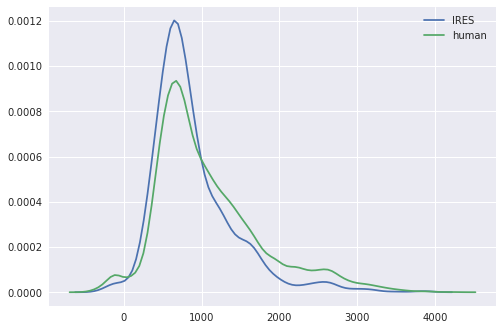

Ks_2sampResult(statistic=0.16277808688586848, pvalue=1.2328972469782333e-31)

In [55]:
import scipy

# sample_effs
# internal_AUG_eff
# scram_eff


# dens_plots = []
# for eff in viral_eff:
#      dens_plots.append(sns.distplot(eff, hist=False))






# all_viral_test_eff = analysis_pipeline(("viral_all_30up_toSTOP.fasta","V"))

sample1 = iv_eff
sample2 = hs_eff

sns.distplot(sample1, hist = False , label = "IRES")
sns.distplot(sample2, hist = False, label = "human")

plt.show()
scipy.stats.ks_2samp(sample1, sample2)

# #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
# scipy.stats.chisquare(hs_eff,ex_eff)

# use the new scoring scheme to scan the entire ORF like what you did in last semester.

In [40]:
# have to scan the TIS + 200 bp downstream


